### Kalshi markets analysis
We use this jupyter notebook to analyze the data we pulled from the Kalshi API.

In [1]:
import pandas as pd
import json

In [2]:
df = pd.read_json("chosen_markets.json")
df.head()

,yes_ask,yes_bid,price,result,close_time,event_ticker,series_ticker,time_until,ticker,category,volume,timestamp
0,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,719,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 18:00:00+00:00
1,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,718,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 19:00:00+00:00
2,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,717,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 20:00:00+00:00
3,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,716,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 21:00:00+00:00
4,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,715,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 22:00:00+00:00


In [3]:
len(df.groupby('ticker')['ticker'])

8199

In [ ]:
def is_informative(prices, result, c):
    """Determine if the prices are consistently informative."""
    if result == "yes":
        return (prices >= c).all()
    else:
        return (prices <= (1-c)).all()

In [37]:
results = []
snapshots = [30*24, 14*24, 7*24, 3*24, 24, 12, 1]


for ticker, df_t in df.groupby("ticker"):
    df_t = df_t.sort_values("time_until")

    result = df_t['result'].iloc[0]

    for snap in snapshots:
        # take all data after this snapshot
        mask = df_t['time_until'] <= snap
        future_prices = df_t.loc[mask, 'price']/100

        informative = is_informative(future_prices, result, c=0.55)

        results.append({
            "ticker": ticker,
            "snapshot": snap,
            "informative": informative,
            "result": result
        })

In [38]:
df_results = pd.DataFrame(results)
df_results.head()

,ticker,snapshot,informative,result
0,AVENGERSDELAY-26MAY01,720,False,yes
1,AVENGERSDELAY-26MAY01,336,False,yes
2,AVENGERSDELAY-26MAY01,168,False,yes
3,AVENGERSDELAY-26MAY01,72,False,yes
4,AVENGERSDELAY-26MAY01,24,False,yes


In [40]:
def drop_after_first_yes(group):
    # Create a mask: True for the first 'yes' and everything before it
    # We use cumsum on the boolean column. 
    # The first 'yes' makes the sum 1. Everything after makes it > 1.
    mask = (group['informative'] == 'yes').shift(1).fillna(0).cumsum() == 0
    return group[mask]

# Application
df_cleaned = df_results.groupby('ticker', group_keys=False).apply(drop_after_first_yes)

/var/folders/4r/f7k5gh050q3_v7khjwbtg6mr0000gn/T/ipykernel_31416/1428516348.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_results.groupby('ticker', group_keys=False).apply(drop_after_first_yes)


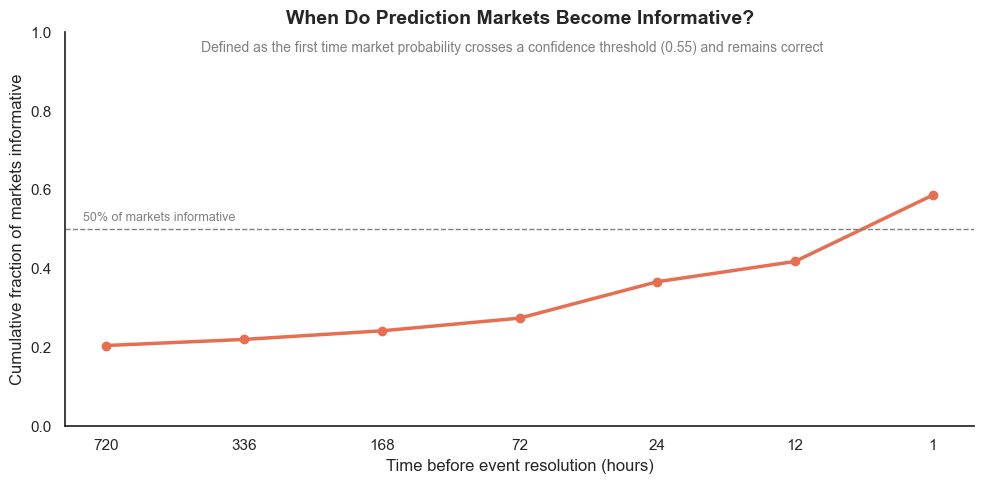

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare data ---
total_tickers = df_cleaned['ticker'].nunique()

first_informative = (
    df_cleaned[df_cleaned['informative'] == True]
    .sort_values('snapshot', ascending=False)
    .groupby('ticker', as_index=False)
    .first()
)


snapshot_counts = (
    first_informative
    .groupby('snapshot')
    .size()
    .reset_index(name='count')
)


snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts = snapshot_counts.sort_values('snapshot', ascending=False)
snapshot_counts['cumulative_fraction'] = snapshot_counts['fraction'].cumsum()


# Use snapshot as categorical (clean spacing)
x_labels = snapshot_counts['snapshot'].astype(str)

# --- Plot ---
sns.set_theme(style="white")

plt.figure(figsize=(10, 5))

plt.plot(
    x_labels,
    snapshot_counts['cumulative_fraction'],
    marker="o",
    linewidth=2.5,
    color="#E76F51"
)

# 50% reference line
plt.axhline(
    0.5,
    linestyle="--",
    linewidth=1,
    color="gray"
)

# Annotate the 50% line
plt.text(
    0.02,
    0.52,
    "50% of markets informative",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="gray"
)

# Axis labels
plt.xlabel("Time before event resolution (hours)")
plt.ylabel("Cumulative fraction of markets informative")
plt.ylim(0, 1)

# Title
plt.title(
    "When Do Prediction Markets Become Informative?",
    fontsize=14,
    weight="bold"
)

# Subtitle
plt.text(
    0.15,
    0.95,
    "Defined as the first time market probability crosses a confidence threshold (0.55) and remains correct",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="gray"
)

# Clean layout
sns.despine()
plt.tight_layout()
plt.show()
